In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy



In [2]:
def myround(x, base=5):
    return base * round(x/base)

In [3]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [4]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [5]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [6]:
durations = []
moments = []
root_times_10 = []
relative_root_times_10 = []
root_times_90 = []
relative_root_times_90 = []
root_times_100 = []
relative_root_times_100 = []

for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
    #print(scardec_name)
    momentrate_opt, time_opt, db = get_stf(scardec_name, wanted_type='fctmoy')

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]
    durations.append(duration)

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
    moments.append(total_moment)
    root_10, r = scipy.optimize.bisect(f3,
                                    start_time+dx,
                                    end_time,
                                    rtol = 1e-6,
                                    full_output = True,
                                    args = (total_moment,
                                            time_opt,
                                            momentrate_opt,
                                            start,
                                            points_before_zero,
                                            0.1,))
    root_idx_10 = np.floor(root_10/dx)
    root_time_10 = root_idx_10*dx
    root_times_10.append(root_time_10)
    relative_root_times_10.append(root_time_10-start_time)

    root_90, r = scipy.optimize.bisect(f3,
                                    start_time+dx,
                                    end_time,
                                    rtol = 1e-6,
                                    full_output = True,
                                    args = (total_moment,
                                            time_opt,
                                            momentrate_opt,
                                            start,
                                            points_before_zero,
                                            0.9,))
    root_idx_90 = np.floor(root_90/dx)
    root_time_90 = root_idx_90*dx
    root_times_90.append(root_time_90)
    relative_root_times_90.append(root_time_90-start_time)

    if (root_time_90-start_time)/duration > 1:
        print(scardec_name)
        print(root_time_90)
        print(start_time)
        print(duration)
        print((root_time_90-start_time)/duration)

root_times_10 = np.array(root_times_10)
durations = np.array(durations)
moments = np.log10(np.array(moments))

rel_root_times_10 = relative_root_times_10/durations

root_times_90 = np.array(root_times_90)

rel_root_times_90 = relative_root_times_90/durations




In [7]:
rel_root_times_90[rel_root_times_90>1] = 1

(array([  1.,   5.,  15.,  24.,  48., 110., 147., 199., 286., 335., 413.,
        410., 419., 388., 374., 291., 260., 190., 139.,  35.]),
 array([0.26457399, 0.29936116, 0.33414834, 0.36893551, 0.40372268,
        0.43850986, 0.47329703, 0.50808421, 0.54287138, 0.57765855,
        0.61244573, 0.6472329 , 0.68202007, 0.71680725, 0.75159442,
        0.78638159, 0.82116877, 0.85595594, 0.89074311, 0.92553029,
        0.96031746]),
 <BarContainer object of 20 artists>)

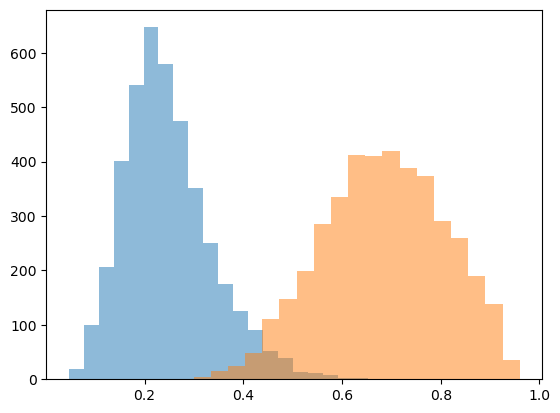

In [8]:
plt.hist(rel_root_times_10, bins = 20, alpha = 0.5)
plt.hist(rel_root_times_90, bins = 20, alpha = 0.5)


In [9]:
max(rel_root_times_90)

0.9603174603174603

In [10]:
relative_root_times_90 = np.array(relative_root_times_90)
relative_root_times_10 = np.array(relative_root_times_10)

In [11]:
last_10 = (durations-relative_root_times_90)
print(min(last_10), max(last_10))

last_10[last_10 < 0] = 0

ratio = relative_root_times_10/last_10

0.2109375 61.3124995


In [12]:
finite_ratio = ratio[np.isfinite(ratio)]
finite_moments = moments[np.isfinite(ratio)]
finite_duration = durations[np.isfinite(ratio)]
print(finite_ratio)

[2.25       0.90540541 0.14814815 ... 0.51923076 0.73809524 1.66666667]


In [13]:
print(np.sort(finite_ratio)[-5:])

[ 6.64285714  6.68181818  7.         10.6        10.75      ]


Text(0.5, 0, 'Ratio of 10% to 90%')

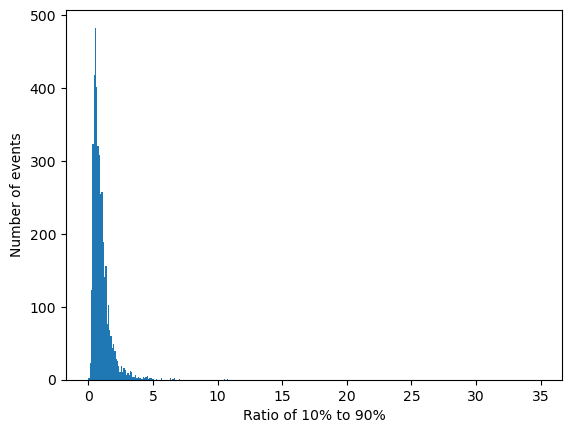

In [14]:
plt.hist(finite_ratio, bins = np.arange(0, 35, 0.1))
plt.ylabel('Number of events')
plt.xlabel('Ratio of 10% to 90%')

(0.0, 35.0)

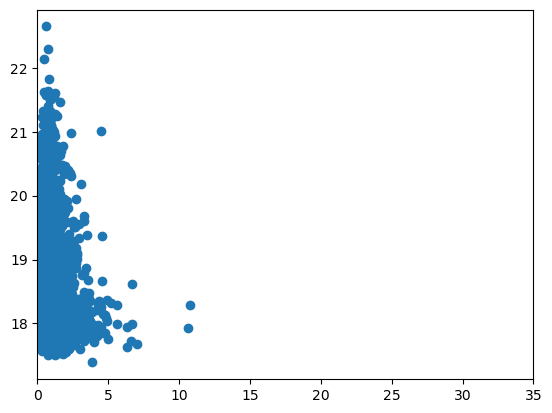

In [15]:
plt.scatter(finite_ratio, finite_moments)
plt.xlim(0, 35)

In [16]:
t_18 = finite_ratio[np.where((finite_moments < 18))[0]]
t_18_19 = finite_ratio[np.where((finite_moments > 18) & (finite_moments < 19))[0]]
t_19_20 = finite_ratio[np.where((finite_moments > 19) & (finite_moments < 20))[0]]
t_20_21 = finite_ratio[np.where((finite_moments > 20) & (finite_moments < 21))[0]]
t_21_22 = finite_ratio[np.where((finite_moments > 21) & (finite_moments < 22))[0]]
t_22 = finite_ratio[np.where((finite_moments > 22))[0]]

columns = ['log10(M0) < 18',
            'log10(M0) in range [18, 19]',
            'log10(M0) in range [19, 20]',
            'log10(M0) in range [20, 21]',
            'log10(M0) in range [21, 22]',
            'log10(M0) > 22']
df = pd.concat([pd.DataFrame(a, columns=[f'{i}, log10(M0) in range [{i+17}, {i+18}]']) for i, a in enumerate([t_18, t_18_19, t_19_20, t_20_21, t_21_22, t_22])], axis=1)
df.columns = columns

df.plot.hist(stacked=True, bins=np.arange(0, 10, 0.1), density=True, figsize=(10, 6), grid=True, colormap = cmc.lajolla)

plt.ylabel('Frequency')
plt.xlabel('Ratio of time to release first 10% of moment to last 10% of moment')
#plt.xlim(0, 1)

NameError: name 'cmc' is not defined

In [ ]:
min(ratio)

-72.99999999999962

In [ ]:
max(ratio)

inf